In [916]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pyswarm import pso
from scipy.optimize import minimize


In [917]:
chips_data = pd.read_csv("chips.csv", header=None)[1:]
chips_X = chips_data.loc[:, 0:1]
chips_y = np.where(chips_data.loc[:, 2] == 'P', 1, -1).astype(np.int8)

In [918]:
geyser_data = pd.read_csv("geyser.csv", header=None)[1:]
geyser_X = geyser_data.loc[:, 0:1]
geyser_y = np.where(geyser_data.loc[:, 2] == 'P', 1, -1).astype(np.int8)

In [919]:
class SVM:
    X_train = None
    y_train = None
    X_test = None
    y_test = None


    def fit(self, X, y, kernel_name='linear', C=1, d=1, xi=1):
        self.X_train = np.array(X, dtype=np.float)
        self.y_train = np.array(y)
        self.N_train = self.X_train.shape[0]
        self.k_train = self.X_train.shape[1]
        self.C = C
        self.w = np.random.sample(self.k_train)
        self.w0 = np.random.random()
        kernels = {
            'linear': lambda a, b: a @ b.T,
            'polynomial': lambda a, b: (a @ b.T + 1)**d,
            'gaussian': lambda a, b: np.exp(-xi * (a - b).sum(axis=1)**2),
        }
        self.kernel = kernels[kernel_name]
        self.__train__()


    def predict(self, X):
        return np.sign(self.K(X))

    def __possitive_cut__(self, x):
        return (x + np.abs(x))/2

    def K(self, X=None, w=None, w0=None):
        X = X if X is not None else self.X_train
        w = w if w is not None else self.w
        w0 = w0 if w0 is not None else self.w0
        return  self.kernel(w, X) - w0


    def __opt_func__(self, lamd):
        a = lamd.reshape((-1,1))
        b = self.y_train.reshape((-1,1))
        M = self.y_train * self.K(w=lamd[0:-1], w0=lamd[-1])
        return self.__possitive_cut__(1 - M).sum() + .5/self.C * np.linalg.norm(lamd[0:-1], 2)
        # return .5 * (a*a.T * b*b.T * (self.X_train @ self.X_train.T)).sum() - a.sum()

    def __constraints__(self, lamd):
        return lamd - (lamd*self.y_train).sum()

    def __train__(self):
        bounds = np.full((self.N_train, self.k_train), (0, self.C))
        constraints = (
            {
                'type': 'eq', 'fun': self.__constraints__
            }
        )
        print(np.hstack((self.w, self.w0)))
        res = minimize(self.__opt_func__, np.hstack((self.w, self.w0)))
        print(res)
        self.w = res.x[0:-1]
        self.w0 = res.x[-1]
        print(self.w)
        print(self.w0)

        # ub = np.full(self.N_train, self.C)
        # lb = np.full(self.N_train, 0)
        # lamd_init = np.random.sample(self.N_train) * self.C
        # lamd, fopt = pso(self.__opt_func__, lb=lb, ub=ub, f_ieqcons=self.__constraints__, swarmsize=100, maxiter=100)
        # self.w = np.array([(lamd * self.y_train * self.X_train[:, 0]).sum(axis=0), (lamd * self.y_train * self.X_train[:, 1]).sum(axis=0)])
        # print((lamd*self.y_train).sum())
        # print(self.w.shape, self.w)
        # print(self.w @ self.X_train.T)
        # print(self.w0)
        # print(self.w @ self.X_train.T - self.w0)
        # M = self.y_train * self.K(w0=1)
        # print(M)
        # M = self.y_train * self.K()
        # print(M)
        # iter = np.squeeze(np.where(np.all(( M == 1, lamd>0), axis=0)))[0]
        # self.w0 = self.w @ self.X_train[iter].T - self.y_train[iter]

    def visualize(self, X=None, y=None):
        X = X or self.X_test or self.X_train
        y = y or self.y_test or self.y_train
        xx, yy = np.meshgrid(np.linspace(X[:,0].min() - 1, X[:,0].max() + 1, 1000), np.linspace(X[:,1].min() - 1, X[:,1].max() + 1, 1000))
        pred = self.predict(np.c_[xx.ravel(), yy.ravel()])
        pred = pred.reshape(xx.shape)

        plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))

        plt.scatter(X[:,0], X[:,1], c=y)
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.show()


[0.90352426 0.77543939 0.89784576]
      fun: 55.77094456969403
 hess_inv: array([[ 2.50517983e-05, -2.50466866e-05,  2.02255189e-09],
       [-2.50466866e-05,  2.50441016e-05,  3.56681386e-09],
       [ 2.02255189e-09,  3.56681386e-09,  2.57575928e-08]])
      jac: array([12.20637131,  7.5001235 , -2.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 400
      nit: 16
     njev: 97
   status: 2
  success: False
        x: array([ 0.03056772, -1.37558403, -4.10496294])
[ 0.03056772 -1.37558403]
-4.104962935646006


<ipython-input-919-a6676e77a69f>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))


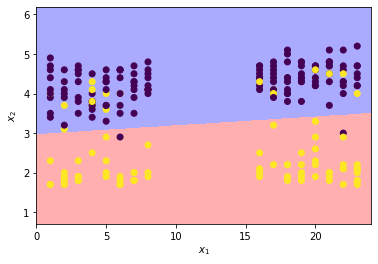

In [920]:
svm = SVM()
# for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
svm.fit(geyser_X, geyser_y)
svm.visualize()

[0.79424799 0.46154778 0.74733413]
      fun: 120.89655783393155
 hess_inv: array([[ 1.82803782e-05, -4.38358085e-05,  1.12364395e-04],
       [-4.38358085e-05,  1.89601076e-04,  4.75339492e-05],
       [ 1.12364395e-04,  4.75339492e-05,  1.92083804e-03]])
      jac: array([14.44385815,  2.93637085, -1.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 408
      nit: 21
     njev: 99
   status: 2
  success: False
        x: array([ 0.06168341, -0.37062336,  1.15443858])
[ 0.06168341 -0.37062336]
1.1544385803941046
[0.67830605 0.18274875 0.40824568]
      fun: 64.46511938679502
 hess_inv: array([[ 4.56932855e-05, -2.21435734e-04,  2.96266279e-05],
       [-2.21435734e-04,  1.08223329e-03, -1.01029805e-04],
       [ 2.96266279e-05, -1.01029805e-04,  8.12650127e-04]])
      jac: array([67.50395966, 17.32090569,  0.        ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 392
      nit: 24
     njev: 95
  

<ipython-input-919-a6676e77a69f>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))
<ipython-input-919-a6676e77a69f>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))
<ipython-input-919-a6676e77a69f>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3. 

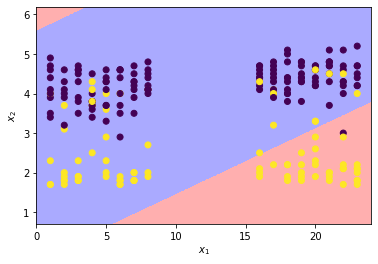

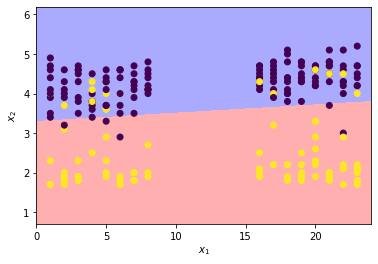

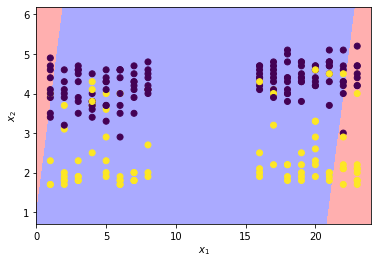

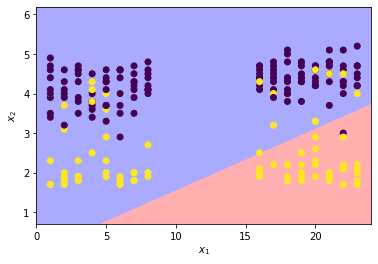

In [921]:
# for C in [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]:
for i in range(2, 6):
    svm.fit(geyser_X, geyser_y, kernel_name='polynomial', d=i)
    svm.visualize()

[0.06518214 0.12987339 0.1103772 ]
      fun: 103.94647140503365
 hess_inv: array([[ 0.12167871, -0.11124191, -0.02485121],
       [-0.11124191,  0.12171429,  0.03453597],
       [-0.02485121,  0.03453597,  0.53573167]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 8
     njev: 20
   status: 0
  success: True
        x: array([0.08271825, 0.08271824, 1.18655678])
[0.08271825 0.08271824]
1.1865567823501624
[0.74998844 0.57554355 0.35052421]
      fun: 100.94320497816622
 hess_inv: array([[ 0.12938237, -0.12284985,  0.00816232],
       [-0.12284985,  0.12932706, -0.0056329 ],
       [ 0.00816232, -0.0056329 ,  0.17446508]])
      jac: array([9.53674316e-07, 1.90734863e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 8
     njev: 18
   status: 0
  success: True
        x: array([0.08913961, 0.08913968, 1.03698001])
[0.08913961 0.08913968]
1.03698001074767
[0.27598377 0.30844081 0

<ipython-input-919-a6676e77a69f>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))
<ipython-input-919-a6676e77a69f>:87: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, pred, cmap=ListedColormap(['#AAAAFF','#FFAFAF']))


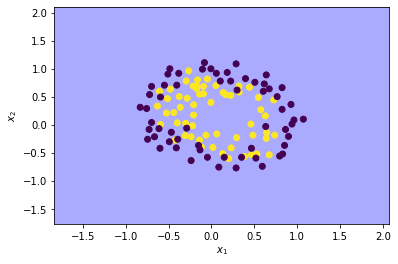

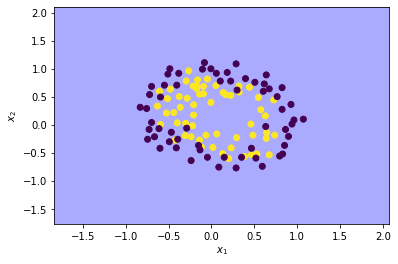

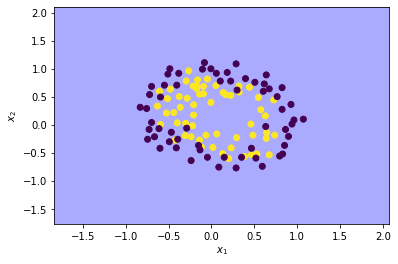

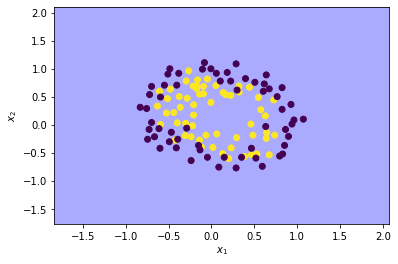

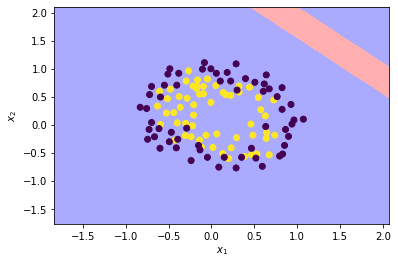

In [922]:
for i in range(1, 6):
    svm.fit(chips_X, chips_y, kernel_name='gaussian', xi=i)
    svm.visualize()
# print(svm.predict(np.array(geyser_X, dtype=np.float)))
# print(geyser_y)